In [1]:
import sys; sys.path.append('../')

import time

from src.data_loader import load_data

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import warnings
warnings.filterwarnings('ignore')

/home/nicolas/.local/share/virtualenvs/point-cloud-learn-97nGMN1k/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/nicolas/.local/share/virtualenvs/point-cloud-learn-97nGMN1k/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
plt.rcParams["figure.figsize"] = (20,10)

# Try to binarize

In [3]:
clusters, _ = load_data('../data/all_clusters_points.txt')
clusters = clusters.drop(['file_origin', 'file_destination'], axis=1)

In [4]:
#Delete columns with one value
for col in clusters.columns:
    if len(clusters[col].unique()) == 1:
        clusters.drop(col,inplace=True,axis=1)

In [5]:
clusters['classification'] = (
    ((clusters['classification'] != 'Vegetation') & (clusters['classification'] != 'Limit_effect'))
)

In [6]:
train_percentage = 0.8

data = clusters.replace('None', np.nan).dropna(axis=0)

X_all = data.drop('classification', axis=1)
X_all = (X_all - X_all.mean()) / X_all.std()
y_all = data['classification']

X = data.drop('classification', axis=1)
X = (X - X.mean()) / X.std()
y = data['classification']

train_indexes, test_indexes = next(StratifiedShuffleSplit(n_splits=1, train_size=0.8).split(X, y))
X_train, y_train = X.iloc[train_indexes], y.iloc[train_indexes]
X_test, y_test = X.iloc[test_indexes], y.iloc[test_indexes]

In [7]:
print(y_test.value_counts(),'\n', y_train.value_counts())

False    1185
True       11
Name: classification, dtype: int64 
 False    4738
True       44
Name: classification, dtype: int64


In [8]:
from sklearn.cluster import KMeans

class_counts = y_train.value_counts().to_dict()
mayority_class = max(class_counts, key=class_counts.get)
mayority_class_index = y_train[y_train == mayority_class].index

num_clusters = min(class_counts.values())

clusters = KMeans(n_clusters=num_clusters)\
                .fit(X_train.loc[mayority_class_index])\
                .cluster_centers_
clusters = pd.DataFrame(
                clusters, columns=X_train.columns
            )

y_train = y_train.drop(mayority_class_index)
X_train = X_train.drop(mayority_class_index)

X_train = pd.concat([X_train, clusters])
y_train = pd.concat([y_train, pd.Series([mayority_class for _ in range(len(clusters))])])

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, RandomForestClassifier, VotingClassifier)
from sklearn.svm import SVC
models = [
    LinearDiscriminantAnalysis, KNeighborsClassifier, RadiusNeighborsClassifier, GaussianNB,
    DecisionTreeClassifier, ExtraTreeClassifier, AdaBoostClassifier, BaggingClassifier,
    ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, SVC
]

In [10]:
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                                f1_score, roc_auc_score, classification_report)

results = {m.__name__: {} for m in models}
all_results = {m.__name__: {} for m in models}
bar_plot = []
bar_plot_all = []
for Model in models:
    t_start = time.time()    
    try:
        model = Model()
        model.fit(X_train, y_train)
        elapsed_time = time.time() - t_start
        
        y_pred = model.predict(X_test)
        results[Model.__name__] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precission': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted'),
            'time': elapsed_time,
            'classification_report': classification_report(y_test, y_pred, labels=y_test.unique(), output_dict=True)
        }
        
        y_pred_all = model.predict(X_all)
        all_results[Model.__name__] = {
            'accuracy': accuracy_score(y_all, y_pred_all),
            'precission': precision_score(y_all, y_pred_all, average='weighted'),
            'recall': recall_score(y_all, y_pred_all, average='weighted'),
            'f1': f1_score(y_all, y_pred_all, average='weighted'),
            'time': elapsed_time,
            'classification_report': classification_report(y_all, y_pred_all, labels=y_test.unique(), output_dict=True)
        }
        
        bar_plot_all.append([Model.__name__, len(y_pred_all), sum(y_pred_all == True), sum(y_all), sum(y_all & y_pred_all)])
        bar_plot.append([Model.__name__, len(y_pred), sum(y_pred == True), sum(y_test), sum(y_test & y_pred)])
    except Exception as e:
        elapsed_time = time.time() - t_start
        results[Model.__name__] = {
            'error': e,
            'time': elapsed_time,
            'classification_report': {}
        }

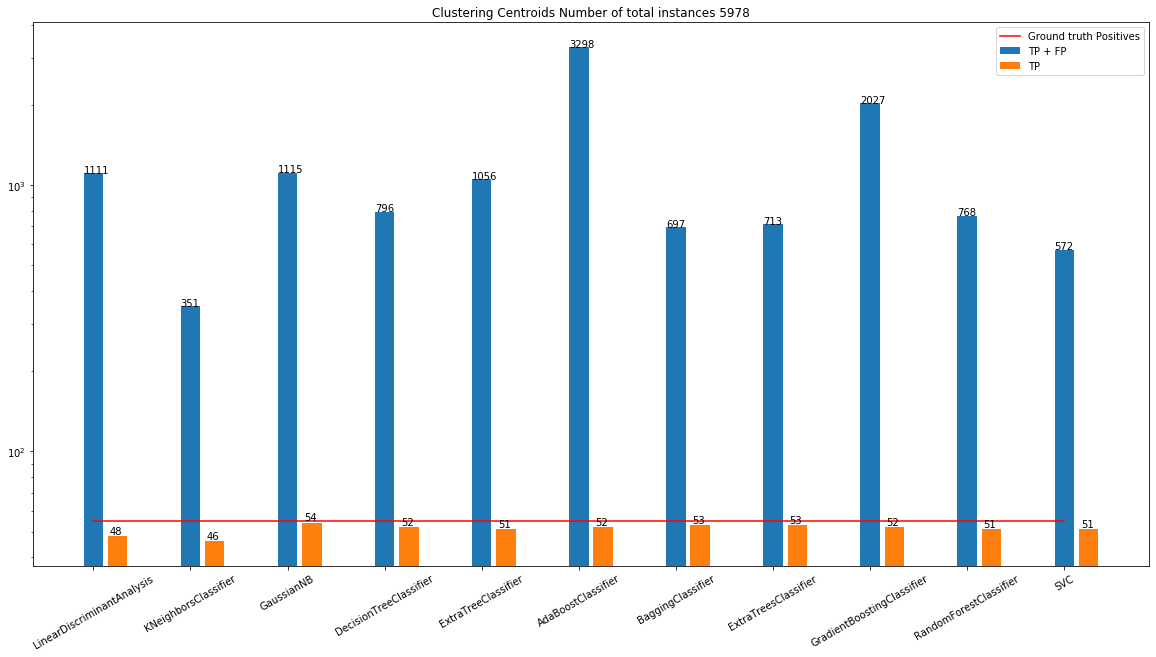

In [11]:
x = np.arange(len(bar_plot_all))

tp_tf = np.array([b[2] for b in bar_plot_all])
plt.bar(x, tp_tf, width=0.2, label='TP + FP')
for i in range(len(x)):
    plt.text(x=x[i] - 0.1, y=tp_tf[i]+1, s=tp_tf[i])

tp = [b[4] for b in bar_plot_all]
plt.bar(x + 0.25, tp, width=0.2, label='TP')
for i in range(len(x)):
    plt.text(x=x[i] + 0.17, y=tp[i]+1, s=tp[i])

plt.plot(x, [b[3] for b in bar_plot_all], label='Ground truth Positives', color='red')

plt.xticks(x, [b[0] for b in bar_plot_all], rotation=30)
plt.yscale('log')
plt.title(f'Clustering Centroids Number of total instances {len(y_all)}')
plt.legend()

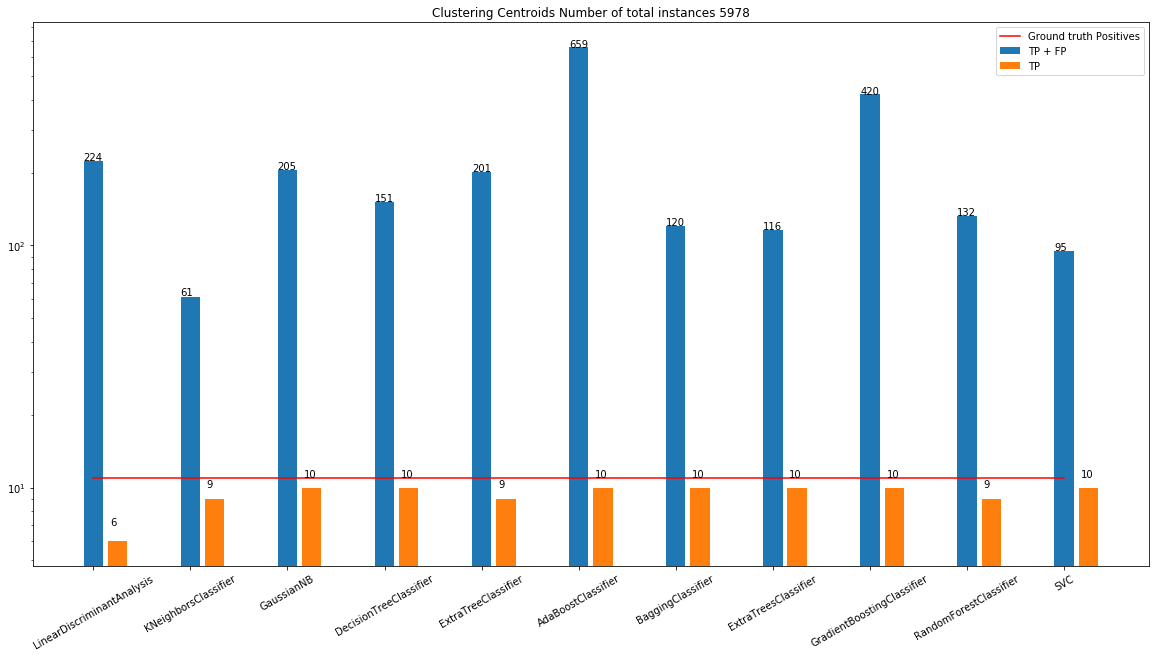

In [12]:
x = np.arange(len(bar_plot))

tp_tf = np.array([b[2] for b in bar_plot])
plt.bar(x, tp_tf, width=0.2, label='TP + FP')
for i in range(len(x)):
    plt.text(x=x[i] - 0.1, y=tp_tf[i]+1, s=tp_tf[i])

tp = [b[4] for b in bar_plot]
plt.bar(x + 0.25, tp, width=0.2, label='TP')
for i in range(len(x)):
    plt.text(x=x[i] + 0.17, y=tp[i]+1, s=tp[i])

plt.plot(x, [b[3] for b in bar_plot], label='Ground truth Positives', color='red')

plt.xticks(x, [b[0] for b in bar_plot], rotation=30)
plt.yscale('log')
plt.title(f'Clustering Centroids Number of total instances {len(y_all)}')
plt.legend()

In [13]:
def print_metric(metric, results=results):
    ys = [r[metric] for r in results.values() if metric in r.keys()]
    xs = range(len(ys))
    labels = [n for n, r in results.items() if metric in r.keys()]

    plt.scatter(xs, ys)
    plt.xticks(xs, labels, rotation='vertical')
    pass

def print_metric_in_cl(metric, cl, results=results):
    ys = [
        r['classification_report'][cl][metric] 
        for r in results.values() 
        if 'classification_report' in r.keys() and cl in r['classification_report'].keys()
    ]
    xs = range(len(ys))
    labels = [n for n, r in results.items() if 'classification_report' in r.keys()]

    plt.scatter(xs, ys)
    plt.xticks(xs, labels, rotation='vertical')
    pass

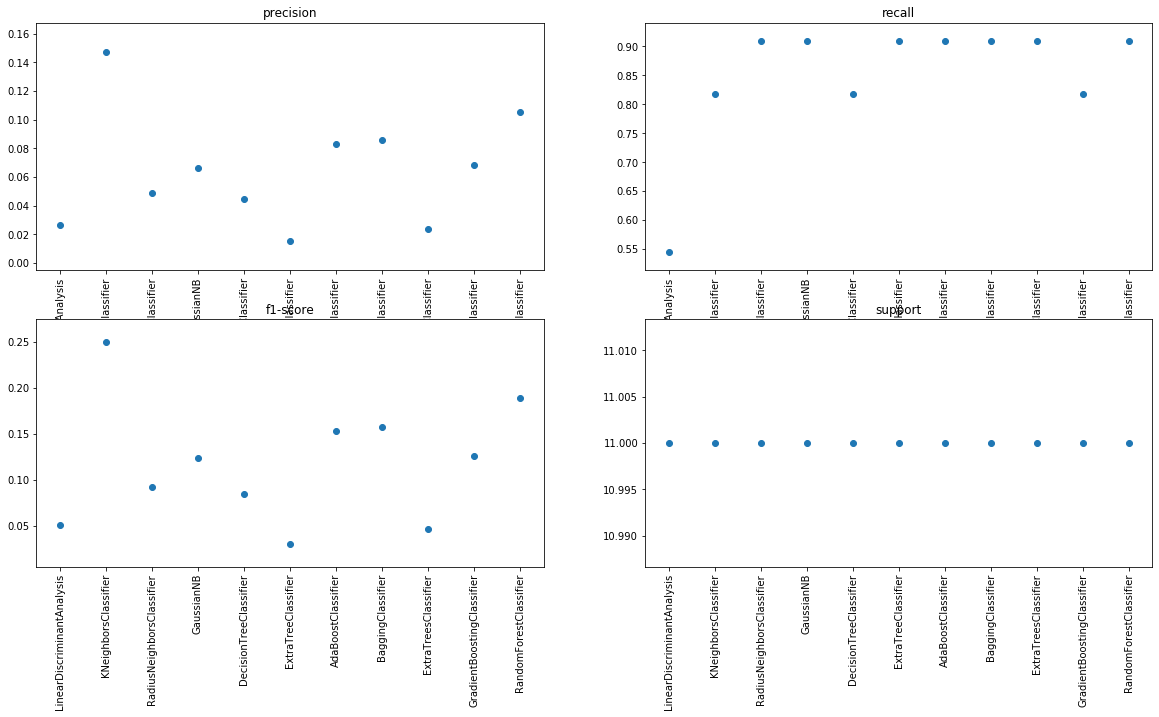

In [14]:
fig = plt.figure()
for i, metric in enumerate(results[list(results.keys())[0]]['classification_report']['True']):
    plt.subplot(2,2,i+1)
    plt.title(metric)
    print_metric_in_cl(metric, 'True')

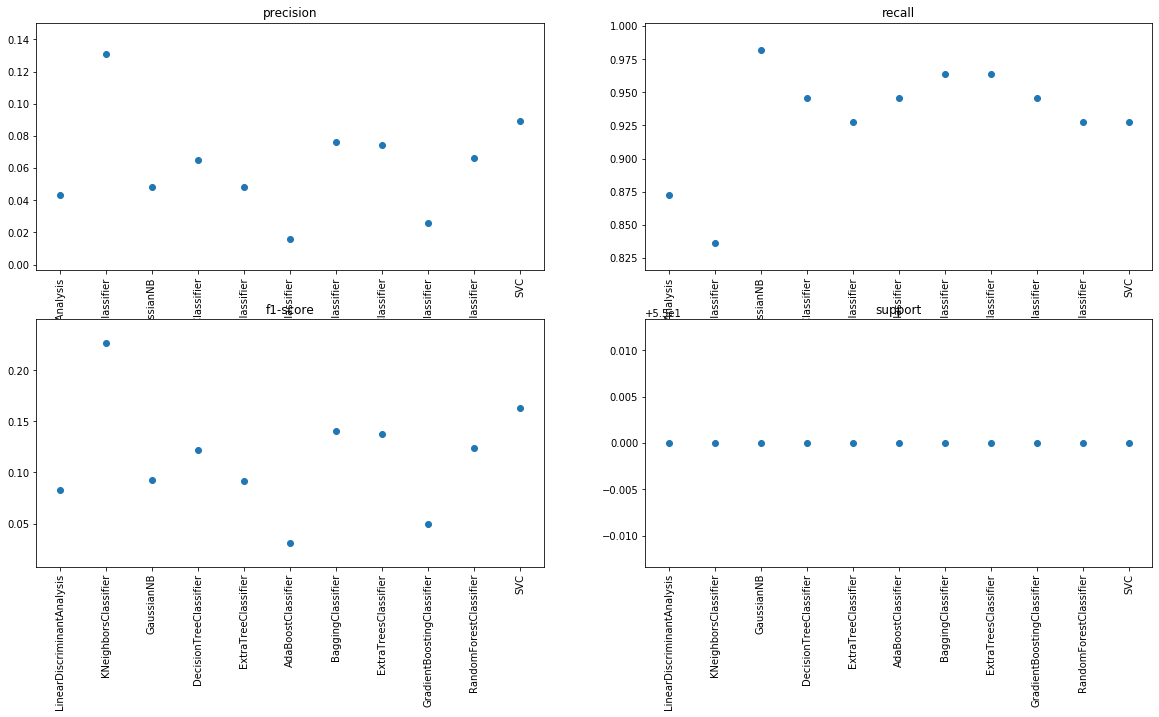

In [15]:
fig = plt.figure()
for i, metric in enumerate(results[list(results.keys())[0]]['classification_report']['True']):
    plt.subplot(2,2,i+1)
    plt.title(metric)
    print_metric_in_cl(metric, 'True', all_results)

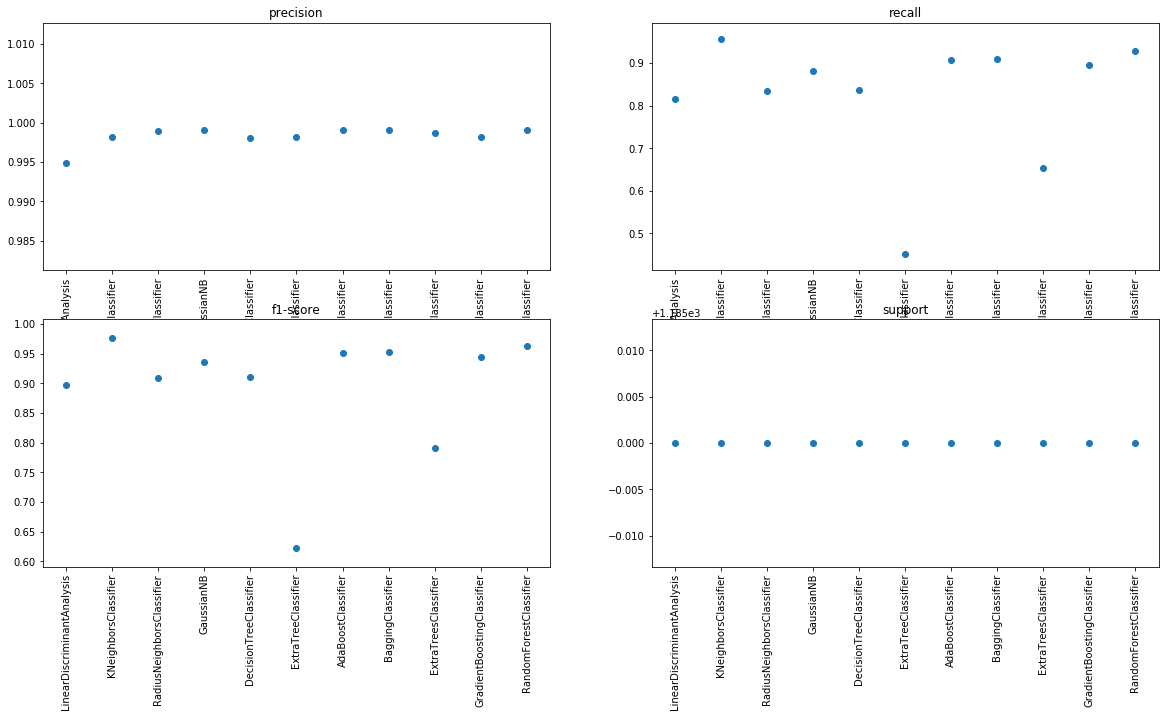

In [16]:
fig = plt.figure()
for i, metric in enumerate(results[list(results.keys())[0]]['classification_report']['False']):
    plt.subplot(2,2,i+1)
    plt.title(metric)
    print_metric_in_cl(metric, 'False')

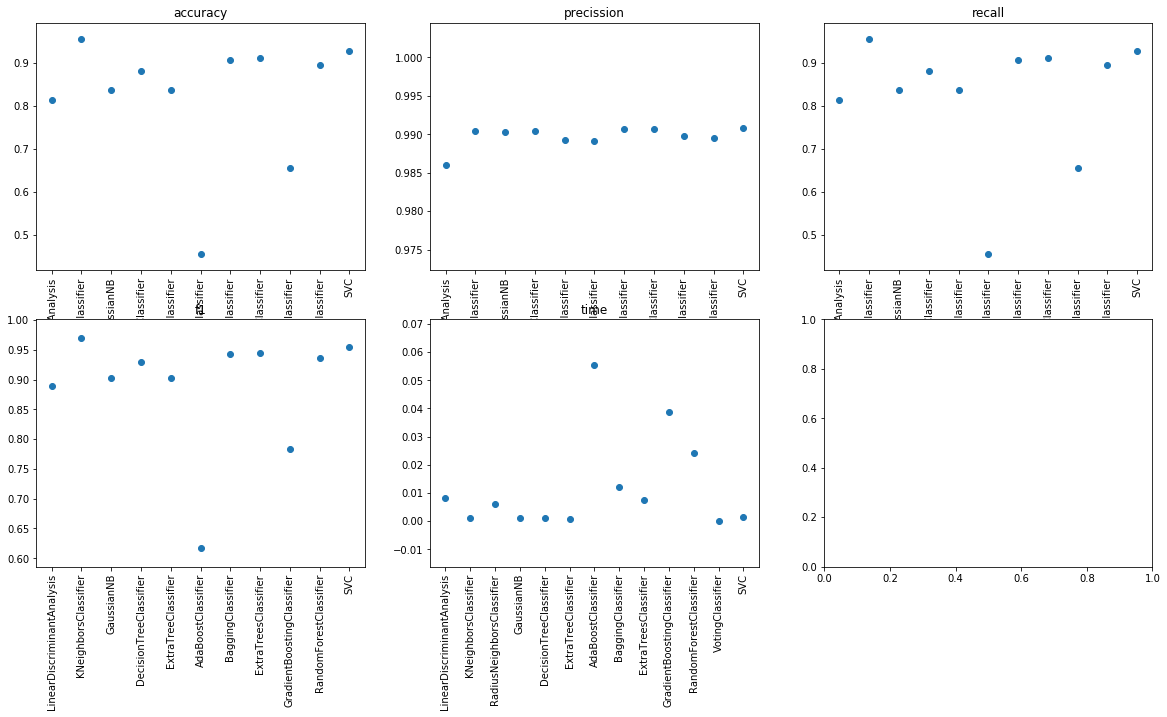

In [17]:
fig = plt.figure()
for i, metric in enumerate(results[list(results.keys())[0]]):
    plt.subplot(2,3,i+1)
    if metric != 'classification_report':
        plt.title(metric)
        print_metric(metric)

In [18]:
max([r['accuracy'] for _, r in results.items() if 'accuracy' in r]),\
max([r['precission'] for _, r in results.items() if 'precission' in r]),\
max([r['recall'] for _, r in results.items() if 'recall' in r]),\

(0.9548494983277592, 0.9908709033937398, 0.9548494983277592)

## Per Class Metrics: Belonging to Candidate or Spread

In [19]:
max([r['classification_report']['True']['precision'] for _, r in results.items() if 'False' in r['classification_report']]),\
max([r['classification_report']['True']['recall'] for _, r in results.items() if 'False'  in r['classification_report']]),\
max([r['classification_report']['True']['f1-score'] for _, r in results.items() if 'False'  in r['classification_report']]),\

(0.14754098360655737, 0.9090909090909091, 0.24999999999999997)

## Per Class Metrics: Not belonging to Candidate or Spread

In [20]:
max([r['classification_report']['False']['precision'] for _, r in results.items() if 'False' in r['classification_report']]),\
max([r['classification_report']['False']['recall'] for _, r in results.items() if 'False'  in r['classification_report']]),\
max([r['classification_report']['False']['f1-score'] for _, r in results.items() if 'False'  in r['classification_report']]),\

(0.9990917347865577, 0.9561181434599156, 0.9767241379310344)